# Processamento de dados - Case iFood

## Imports e carregando as bases

In [0]:
from pyspark.sql.functions import (
    col, sum, mean, when, count, explode, array_contains,
    countDistinct, max, substring, last, datediff, lit, concat
)
from pyspark.sql.window import Window

import matplotlib.pyplot as plt

In [0]:
profile = spark.table("workspace.default.profile")
offers = spark.table("workspace.default.offers")
transactions = spark.table("workspace.default.transactions_clean")

## Entendimento e pre-processamento

### Profile

#### Coluna de idade

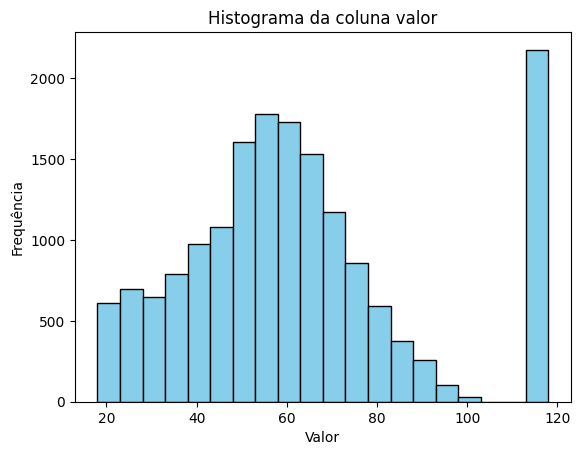

In [0]:
hist_df = profile.select("age").toPandas()

plt.hist(hist_df['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.title('Histograma da coluna valor')
plt.show()

# Observa-se um pico anormal de idades acima de 110 anos,
# indicando possíveis outliers ou problemas de qualidade de dados.


In [0]:
profile.filter(col("age") == 118).count()

# O pico observado é explicado por um grande número de registros
# com idade igual a 118 anos.

2175

In [0]:
profile.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in profile.columns
]).display()

# e apesar das outras colunas posuirem valores nulos, a coluna de idade não possui

age,credit_card_limit,gender,id,registered_on
0,2175,2175,0,0


In [0]:
profile.filter(col("age") == 118).agg(
    sum(col("gender").isNull().cast("int")).alias("null_gender_count")
).display()

# Observa-se que os valores nulos em outras colunas
# ocorrem exatamente nos registros com idade igual a 118,
# indicando erro sistemático de cadastro.

null_gender_count
2175


In [0]:
profile = profile.withColumn(
    "age_backup", 
    col("age")
).withColumn(
    "age",
    when(col("age") == 118, None).otherwise(col("age"))
)

# Idades iguais a 118 anos foram tratadas como valores ausentes,
# preservando o valor original em uma coluna de backup.

#### Colunas de genero e limite no cartão

In [0]:
profile.select("age", "credit_card_limit").summary().show()
profile.groupBy("gender").count().show()

# Os valores de limite de crédito aparentam ser elevados,
# conferir com o time de negócios se fazem sentido?


+-------+------------------+-----------------+
|summary|               age|credit_card_limit|
+-------+------------------+-----------------+
|  count|             14825|            14825|
|   mean| 54.39352445193929| 65404.9915682968|
| stddev|17.383705365854993|21598.29941022947|
|    min|                18|          30000.0|
|    25%|                42|          49000.0|
|    50%|                55|          64000.0|
|    75%|                66|          80000.0|
|    max|               101|         120000.0|
+-------+------------------+-----------------+

+------+-----+
|gender|count|
+------+-----+
|  NULL| 2175|
|     F| 6129|
|     M| 8484|
|     O|  212|
+------+-----+



#### Coluna de dia de registro e criação da coluna de tenure

In [0]:
profile = profile.withColumn(
    "registered_date",
    concat(
        col("registered_on").substr(1, 4), lit("-"),
        col("registered_on").substr(5, 2), lit("-"),
        col("registered_on").substr(7, 2)
    ).cast("date")
)

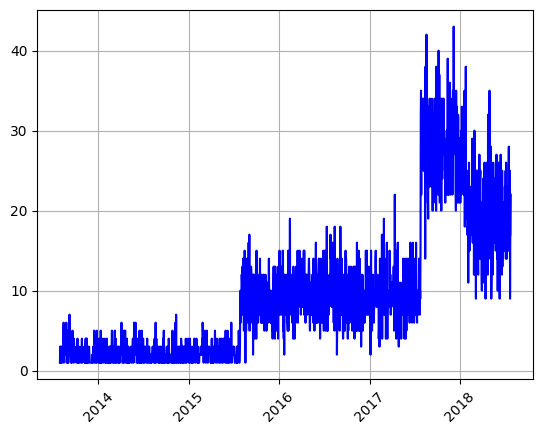

In [0]:
plot_data = profile.groupby(col("registered_date")).count().sort("registered_date").toPandas()

plt.plot(plot_data['registered_date'], plot_data['count'], color='blue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# A visualização diária apresenta muito ruído

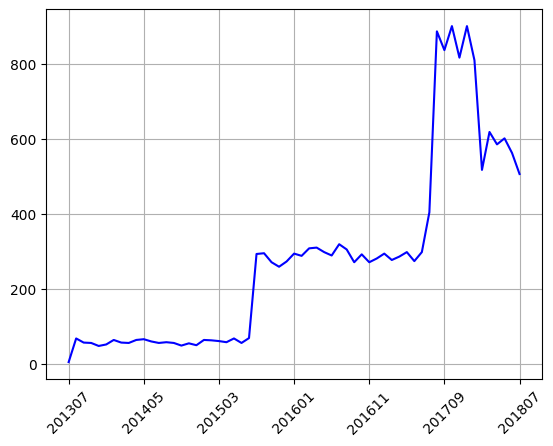

In [0]:
plot_data = profile.withColumn(
    "registered_year_month",
    substring(col("registered_on").cast("string"), 1, 6)
).groupby(col("registered_year_month")).count().sort("registered_year_month").toPandas()

plt.plot(plot_data['registered_year_month'], plot_data['count'], color='blue')
plt.xticks(plot_data['registered_year_month'][::10], rotation=45)
plt.grid(True)
plt.show()

In [0]:
# Criação da variável de tempo de relacionamento do cliente

max_date = (
    profile
    .select(max(col("registered_date").cast("date")).alias("max_date"))
    .collect()[0]["max_date"]
)

profile = profile.withColumn(
    "tenure",
    datediff(
        lit(max_date),
        col("registered_date")
    )
)

In [0]:
profile_clean = profile.select(
    col("id").alias("account_id"),
    col("age"),
    col("credit_card_limit"),
    col("gender"),
    col("tenure"),
    when(col("gender").isNull(), 1).otherwise(0).alias("problema_cadastro")
)

### Transactions

In [0]:
transactions.limit(5).display()

event,account_id,time_since_test_start,offer_id,reward,amount
offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,null,null
offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,null,null
offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,null,null
offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,null,null
offer received,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,null,null


In [0]:
# Entendendo a base

transactions.filter(col("offer_id").isNotNull()) \
    .groupby(col("account_id"), col("offer_id")) \
    .count() \
    .sort(col("count"), ascending=False) \
    .limit(5) \
    .display()

account_id,offer_id,count
2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,10
23d67a23296a485781e69c109a10a1cf,5a8bc65990b245e5a138643cd4eb9837,10
6d2db3aad94648259e539920fc2cf2a6,f19421c1d4aa40978ebb69ca19b0e20d,10
eece6a9a7bdd4ea1b0f812f34fc619d6,5a8bc65990b245e5a138643cd4eb9837,10
c081384f13c441d38583a0f9fa0f3c25,3f207df678b143eea3cee63160fa8bed,8


In [0]:
transactions.filter(
    (col("offer_id") == "f19421c1d4aa40978ebb69ca19b0e20d") & 
    (col("account_id") == "6d2db3aad94648259e539920fc2cf2a6")
).display()

# Um mesmo cliente pode receber a mesma oferta múltiplas vezes.

event,account_id,time_since_test_start,offer_id,reward,amount
offer received,6d2db3aad94648259e539920fc2cf2a6,0.0,f19421c1d4aa40978ebb69ca19b0e20d,null,null
offer viewed,6d2db3aad94648259e539920fc2cf2a6,0.0,f19421c1d4aa40978ebb69ca19b0e20d,null,null
offer received,6d2db3aad94648259e539920fc2cf2a6,7.0,f19421c1d4aa40978ebb69ca19b0e20d,null,null
offer viewed,6d2db3aad94648259e539920fc2cf2a6,7.0,f19421c1d4aa40978ebb69ca19b0e20d,null,null
offer received,6d2db3aad94648259e539920fc2cf2a6,14.0,f19421c1d4aa40978ebb69ca19b0e20d,null,null
offer viewed,6d2db3aad94648259e539920fc2cf2a6,14.0,f19421c1d4aa40978ebb69ca19b0e20d,null,null
offer received,6d2db3aad94648259e539920fc2cf2a6,17.0,f19421c1d4aa40978ebb69ca19b0e20d,null,null
offer viewed,6d2db3aad94648259e539920fc2cf2a6,17.0,f19421c1d4aa40978ebb69ca19b0e20d,null,null
offer received,6d2db3aad94648259e539920fc2cf2a6,24.0,f19421c1d4aa40978ebb69ca19b0e20d,null,null
offer viewed,6d2db3aad94648259e539920fc2cf2a6,24.5,f19421c1d4aa40978ebb69ca19b0e20d,null,null


In [0]:
transactions.select("event").distinct().display()

# A base possui apenas quatro tipos distintos de eventos.

event
offer received
offer viewed
transaction
offer completed


In [0]:
transactions.groupby(col("event")).agg(
    mean(col("reward").isNull().cast("int")).alias("reward_null"), 
    mean(col("amount").isNull().cast("int")).alias("amount_null")
).display()

# A coluna reward só é preenchida para eventos de offer completed,
# enquanto amount é preenchida apenas para eventos de transaction.

event,reward_null,amount_null
offer received,1.0,1.0
offer viewed,1.0,1.0
transaction,1.0,0.0
offer completed,0.0,1.0


In [0]:
transactions.groupby(col("account_id"), col("offer_id")).agg(
    sum((col("event") == "offer received").cast("int")).alias("offer_received_count"),
    sum((col("event") == "offer completed").cast("int")).alias("offer_completed_count")
) \
.filter(col("offer_id").isNotNull()).sort(col("offer_completed_count"), ascending = False) \
.limit(5).display()

# Quando a oferta é "completada" ela vem sem o offer_id

account_id,offer_id,offer_received_count,offer_completed_count
8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,2,0
a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,3,0
78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0
e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,0
68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0


In [0]:
transactions.groupby(col("offer_id").isNull()).agg(
    sum((col("time_since_test_start").isNull()).cast("int")).alias("null_time"),
    sum((col("event") == "offer received").cast("int")).alias("offer_received_count"),
    sum((col("event") == "offer viewed").cast("int")).alias("offer_viewed_count"),
    sum((col("event") == "transaction").cast("int")).alias("transaction_count"),
    sum((col("event") == "offer completed").cast("int")).alias("offer_completed_count")
).display()

# Conferindo a conclusão da celula anterior 
# percebe-se que quando acontece a transação também não está linkada com a offer_id

(offer_id IS NULL),null_time,offer_received_count,offer_viewed_count,transaction_count,offer_completed_count
false,0,76277,57725,0,0
true,0,0,0,138953,33579


In [0]:
transactions.filter(
    col("event") == "offer completed"
).sort(col("time_since_test_start")).limit(5).display()

# Algumas transações são feitas no tempo 0, ou seja, teria tempo do cliente ter visto a oferta?

event,account_id,time_since_test_start,offer_id,reward,amount
offer completed,676506bad68e4161b9bbaffeb039626b,0.0,null,10.0,null
offer completed,fe97aa22dd3e48c8b143116a8403dd52,0.0,null,2.0,null
offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,null,2.0,null
offer completed,629fc02d56414d91bca360decdfa9288,0.0,null,5.0,null
offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.0,null,10.0,null


In [0]:
transactions.filter(col("event") == "transaction").select("time_since_test_start").summary().display()

summary,time_since_test_start
count,138953
mean,15.899347261304182
stddev,8.404051264196976
min,0.0
25%,8.75
50%,16.75
75%,23.0
max,29.75


Databricks visualization. Run in Databricks to view.

In [0]:
transactions.groupby(col("account_id")).agg(
    countDistinct(col("offer_id")).alias("distinct_offer_id_count")
).limit(5).display()

# Um cliente pode receber mais de uma oferta

account_id,distinct_offer_id_count
78afa995795e4d85b5d9ceeca43f5fef,4
a03223e636434f42ac4c3df47e8bac43,3
e2127556f4f64592b11af22de27a7932,4
8ec6ce2a7e7949b1bf142def7d0e0586,4
68617ca6246f4fbc85e91a2a49552598,5


In [0]:
transactions = transactions.withColumn(
    "event_priority",
    when(col("event") == "offer received", 1)
    .when(col("event") == "offer viewed", 2)
    .when(col("event") == "transaction", 3)
    .when(col("event") == "offer completed", 4)
    .otherwise(5)
)

window_spec = (
    Window
    .partitionBy("account_id")
    .orderBy("time_since_test_start", "event_priority")
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)
)

transactions = (
    transactions
    .withColumn(
        "last_offer_id",
        last("offer_id", ignorenulls=True).over(window_spec)
    )
)

# Para inferir qual oferta estava ativa para o cliente no momento da transação,
# selecinou-se a offer_id do evento anterior mais próximo.
# Foi criada uma prioridade entre os eventos para o caso de que dois eventos aconteçam no mesmo intervalo

transactions.limit(5).display()

event,account_id,time_since_test_start,offer_id,reward,amount,event_priority,last_offer_id
offer received,0009655768c64bdeb2e877511632db8f,7.0,5a8bc65990b245e5a138643cd4eb9837,null,null,1,5a8bc65990b245e5a138643cd4eb9837
offer viewed,0009655768c64bdeb2e877511632db8f,8.0,5a8bc65990b245e5a138643cd4eb9837,null,null,2,5a8bc65990b245e5a138643cd4eb9837
transaction,0009655768c64bdeb2e877511632db8f,9.5,null,null,22.16,3,5a8bc65990b245e5a138643cd4eb9837
offer received,0009655768c64bdeb2e877511632db8f,14.0,3f207df678b143eea3cee63160fa8bed,null,null,1,3f207df678b143eea3cee63160fa8bed
offer viewed,0009655768c64bdeb2e877511632db8f,15.5,3f207df678b143eea3cee63160fa8bed,null,null,2,3f207df678b143eea3cee63160fa8bed


In [0]:
transactions.withColumn(
    "transaction_time",
    max(col("time_since_test_start")).over(Window.partitionBy("account_id", "last_offer_id"))
).limit(5).display()

# Conferindo

event,account_id,time_since_test_start,offer_id,reward,amount,event_priority,last_offer_id,transaction_time
offer received,0009655768c64bdeb2e877511632db8f,24.0,2906b810c7d4411798c6938adc9daaa5,null,null,1,2906b810c7d4411798c6938adc9daaa5,29.0
transaction,0009655768c64bdeb2e877511632db8f,24.0,null,null,10.27,3,2906b810c7d4411798c6938adc9daaa5,29.0
offer completed,0009655768c64bdeb2e877511632db8f,24.0,null,2.0,null,4,2906b810c7d4411798c6938adc9daaa5,29.0
transaction,0009655768c64bdeb2e877511632db8f,27.5,null,null,12.36,3,2906b810c7d4411798c6938adc9daaa5,29.0
transaction,0009655768c64bdeb2e877511632db8f,28.75,null,null,28.16,3,2906b810c7d4411798c6938adc9daaa5,29.0


In [0]:
transactions.filter(
    (col("account_id") == "0009655768c64bdeb2e877511632db8f") & 
    (col("last_offer_id") == "2906b810c7d4411798c6938adc9daaa5")
).display()

# Conferindo

event,account_id,time_since_test_start,offer_id,reward,amount,event_priority,last_offer_id
offer received,0009655768c64bdeb2e877511632db8f,24.0,2906b810c7d4411798c6938adc9daaa5,null,null,1,2906b810c7d4411798c6938adc9daaa5
transaction,0009655768c64bdeb2e877511632db8f,24.0,null,null,10.27,3,2906b810c7d4411798c6938adc9daaa5
offer completed,0009655768c64bdeb2e877511632db8f,24.0,null,2.0,null,4,2906b810c7d4411798c6938adc9daaa5
transaction,0009655768c64bdeb2e877511632db8f,27.5,null,null,12.36,3,2906b810c7d4411798c6938adc9daaa5
transaction,0009655768c64bdeb2e877511632db8f,28.75,null,null,28.16,3,2906b810c7d4411798c6938adc9daaa5
transaction,0009655768c64bdeb2e877511632db8f,29.0,null,null,18.41,3,2906b810c7d4411798c6938adc9daaa5


In [0]:
transactions \
    .filter(col("event") == "transaction") \
    .groupby("account_id", "last_offer_id") \
    .agg(count("event").alias("transaction_count")) \
    .limit(5) \
    .display()


account_id,last_offer_id,transaction_count
0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2
0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,4
00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,3


In [0]:
transactions_engineered = transactions.groupby(
    col("account_id"), 
    col("last_offer_id").alias("offer_id")
).agg(
    sum((col("event") == "offer received").cast("int")).alias("n_offers_received"),
    sum((col("event") == "offer viewed").cast("int")).alias("n_offers_viewed"),
    max((col("event") == "transaction").cast("int")).alias("target"),
    sum(col("amount")).alias("amount_transactioned")
)

### Offers

In [0]:
# Cada linha da tabela representa uma oferta única
offers.groupby(col("id")).count().sort(col("count"), ascending = False).display()
offers.filter(col("id") == "f19421c1d4aa40978ebb69ca19b0e20d").display()

id,count
f19421c1d4aa40978ebb69ca19b0e20d,1
2298d6c36e964ae4a3e7e9706d1fb8c2,1
fafdcd668e3743c1bb461111dcafc2a4,1
5a8bc65990b245e5a138643cd4eb9837,1
4d5c57ea9a6940dd891ad53e9dbe8da0,1
0b1e1539f2cc45b7b9fa7c272da2e1d7,1
ae264e3637204a6fb9bb56bc8210ddfd,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3f207df678b143eea3cee63160fa8bed,1
2906b810c7d4411798c6938adc9daaa5,1


channels,discount_value,duration,id,min_value,offer_type
"List(web, email, mobile, social)",5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5,bogo


In [0]:
# Identificação dos canais disponíveis e dos tipos de oferta existentes

offers.select(explode("channels").alias("channel")).distinct().show()
offers.select("offer_type").distinct().show()

+-------+
|channel|
+-------+
| mobile|
|  email|
| social|
|    web|
+-------+

+-------------+
|   offer_type|
+-------------+
|         bogo|
|informational|
|     discount|
+-------------+



In [0]:
offers_clean = (
    offers.withColumnRenamed("id", "offer_id")
    .withColumn("channel_web", array_contains(col("channels"), "web").cast("int"))
    .withColumn("channel_email", array_contains(col("channels"), "email").cast("int"))
    .withColumn("channel_mobile", array_contains(col("channels"), "mobile").cast("int"))
    .withColumn("channel_social", array_contains(col("channels"), "social").cast("int"))

    # Como o modelo será LGBM, não foi necessário criar o one-hot-enconding do tipo de oferta
    # .withColumn("offer_bogo", (col("offer_type") == "bogo").cast("int"))
    # .withColumn("offer_informational", (col("offer_type") == "informational").cast("int"))
    # .withColumn("offer_discount", (col("offer_type") == "discount").cast("int"))
    
)

## Merge das bases e criação do dataset final

In [0]:
# agora o merge
df_model = (
    transactions_engineered
    .join(offers_clean, on = "offer_id", how = "left")
    .join(profile_clean, on = "account_id", how = "left")
)


In [0]:
display(
    profile_clean.join(transactions, "account_id", "left_anti")
)

display(
    offers_clean.join(transactions, "offer_id", "left_anti")
)

# Na base de transações não há contas ou ofertas que não existam nas respectivas bases

account_id,age,credit_card_limit,gender,tenure,problema_cadastro


offer_id,channels,discount_value,duration,min_value,offer_type,channel_web,channel_email,channel_mobile,channel_social


In [0]:
# Remoção de registros sem oferta associada
# e clientes com problemas de cadastro

df_model = df_model.filter(
    (col("offer_id").isNotNull()) &
    (col("problema_cadastro") == 0)
)

In [0]:
df_model.groupBy("account_id", "offer_id") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(5) \
    .display()

account_id,offer_id,count
004b041fbfe44859945daa2c7f79ee64,fafdcd668e3743c1bb461111dcafc2a4,1
004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1
00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,1
004b041fbfe44859945daa2c7f79ee64,3f207df678b143eea3cee63160fa8bed,1
00840a2ca5d2408e982d56544dc14ffd,fafdcd668e3743c1bb461111dcafc2a4,1


In [0]:
df_model.write.saveAsTable("df_model2")